Problem statement :

Rating prediction is a well-known recommendation task aiming to predict a user’s rating for those items which were not rated yet by her. Predictions are computed from users’ explicit feedback, i.e. their ratings provided on some items in the past. Another type of feedback are user reviews provided on items which implicitly express users’ opinions on items. Recent studies indicate that opinions inferred from users’ reviews on items are strong predictors of user’s implicit feedback or even ratings and thus, should be utilized in computation. As far as we know, all the recent works on recommendation techniques utilizing opinions inferred from users’ reviews are either focused on the item recommendation task or use only the opinion information, completely leaving users’ ratings out of consideration. The approach proposed in this paper is filling this gap, providing a simple, personalized and scalable rating prediction framework utilizing both ratings provided by users and opinions inferred from their reviews.

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [14]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
#importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#importing nltk libraries
import nltk

#nltk.download('all')
from nltk.corpus import stopwords
import re
import string
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,precision_score, confusion_matrix, accuracy_score,classification_report

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [17]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [18]:
#loading the data into a dataframe
df = pd.read_csv(r"C:\Users\Rahul\REViewFinal1.csv")
df

,Reviews,Ratings,Unnamed: 2
0,Received this yesterday (04/03/2021). Prompt d...,4.0 out of 5 stars,NaN
1,Different charger was sent in the box by Amazo...,1.0 out of 5 stars,NaN
2,Amazing laptop.. I ordered this laptop on its ...,5.0 out of 5 stars,NaN
3,As soon as I found 11gen Gen i5 at ~62K I got ...,4.0 out of 5 stars,NaN
4,Your browser does not support HTML5 video.\n D...,1.0 out of 5 stars,NaN
...,...,...,...
2145,Superb I got this as gift to my brother and he...,5.0 out of 5 stars,NaN
2146,Received ipad mini5 from appario retailor(thou...,4.0 out of 5 stars,NaN
2147,This is a poweehouse . I bought this thing onl...,5.0 out of 5 stars,NaN
2148,Unbelievable gaming performance under 35k.,5.0 out of 5 stars,NaN


Feature Information:
Review_title : title of the review
Review_text : content of the review text
Ratings : ratings out of 5 stars
At first I will drop the unwanted column Unnamed: 0

In [19]:
df.drop(columns = 'Unnamed: 2',inplace = True)

In [20]:
#checking the shape
print("Shape :", df.shape)

Shape : (2150, 2)


our data set is having 77550 rows and three columns now

In [21]:
#checking column names
print("Columns :", df.columns)

Columns : Index(['Reviews', 'Ratings'], dtype='object')


In [22]:
#data types
df.dtypes

Reviews    object
Ratings    object
dtype: object

In [23]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2150 entries, 0 to 2149
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Reviews  2098 non-null   object
 1   Ratings  2150 non-null   object
dtypes: object(2)
memory usage: 33.7+ KB


By checking all above observations we can say the data contains three columns Review_title , Reiew_text and Ratings. All columns are object type. Here Ratings column is our target column.

In [24]:
#missing values
df.isnull().sum()

Reviews    52
Ratings     0
dtype: int64

The data set is having lot of missing values and we will drop these values.

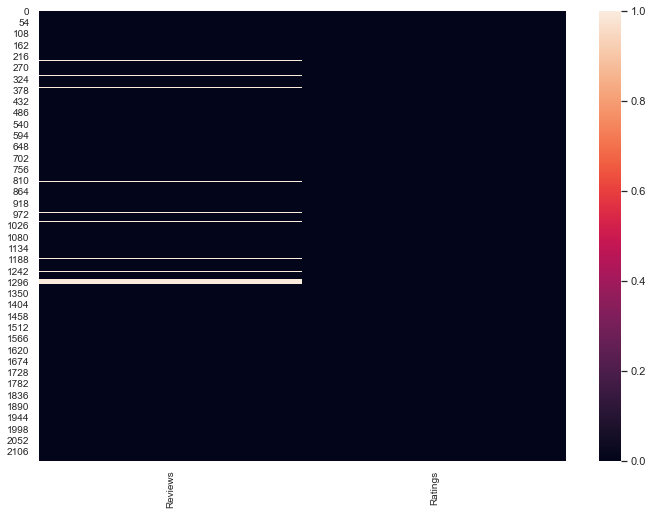

In [25]:
#Visualization of missing values
sns.set(rc={'figure.figsize':(11.8,8.27)})
sns.heatmap(data=df.isnull())
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [26]:
#Drop the rows where review has null values
df.dropna(subset=['Reviews'], inplace=True)

In [27]:
#checking for null values again
df.isnull().sum()

Reviews    0
Ratings    0
dtype: int64

In [28]:
#lets check the shape of our data set now
df.shape

(2098, 2)

Lets have a look at our target column

In [29]:
df['Ratings'].unique()

array(['4.0 out of 5 stars', '1.0 out of 5 stars', '5.0 out of 5 stars',
       '2.0 out of 5 stars', '3.0 out of 5 stars'], dtype=object)

#Looking at these entries in target column we came to know that we need to replace the string entries to respective values(stars)

In [30]:
df['Ratings'] = df['Ratings'].replace('1.0 out of 5 stars',1)
df['Ratings'] = df['Ratings'].replace('2.0 out of 5 stars',2)
df['Ratings'] = df['Ratings'].replace('3.0 out of 5 stars',3)
df['Ratings'] = df['Ratings'].replace('4.0 out of 5 stars',4)
df['Ratings'] = df['Ratings'].replace('5.0 out of 5 stars',5)
df['Ratings'] = df['Ratings'].astype('int')

In [31]:
df['Ratings'].unique()

array([4, 1, 5, 2, 3])

Visualizing text in first three rows from Review column

In [32]:
df['Reviews'][0]

'Received this yesterday (04/03/2021). Prompt delivery by Amazon (as expected).\n\nClarifications/issue points:\n\n1. It’s a plastic body and not aluminium.\n2. Hinges do not lift the lower part of the laptop.\n3. Fan noise is there and it tends to get a bit hot.\n4. There’s no special point on the edge of the lid to easily open it. You need to struggle a bit.\n5. Battery life is descent with normal everyday usage (apprx- 5-6 hours)\n6. Quality of adapter is not that good and the pin connector is not that good in terms of quality. You have to be cautious.\n7. Body is prone to scratches and if you buy silver colour, then they will be visible easily. So be cautious in that area as well.\n8. The packaging quality seemed to be very low. It was all dusty. I had to clean a lot. Laptop also got some dust on it’s body although it was packed well inside a plastic sheet.\n\nPros:\n\n1. Configuration is best at this price level.\n2. Performance is excellent in terms of multi-media usage and onlin

In [33]:
df['Reviews'][1]

"Different charger was sent in the box by Amazon and they were not ready to provide a replacement as I had open the laptop box.\nLater after several calls and struggle I was able to get the replacement and now, camera is not working for the laptop.\nLaptop's over-all performance is nice. Buy it from a HP showroom directly instead buying it from Amazon."

In [34]:
df['Reviews'][2]

"Amazing laptop.. I ordered this laptop on its released date i.e. 24th feb seeing it's wonderful configuration.. I must say the decision was right..\nThank u HP for this superfast laptop. And after so much of research, I think in HP this is the only laptop with high configuration (11th gen, 16gb ram, 512 SSD, 14 inch screen, light weight, finger sensor & Alexa inbuilt) under this budget."

# Text Processing

In [35]:
#Here I am defining a function to replace some of the contracted words to their full form and removing urls and some unwanted text 
def decontracted(text):
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don’t", "do not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"im ", "i am", text)
    text = re.sub(r"yo ", "you ",text)
    text = re.sub(r"doesn’t", "does not",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"<br>", " ", text)
    text = re.sub(r'http\S+', '', text) #removing urls
    return text

In [36]:
#Lowercasing
df['Reviews'] = df['Reviews'].apply(lambda x : x.lower())

df['Reviews'] = df['Reviews'].apply(lambda x : decontracted(x))

#removing punctuations
df['Reviews'] = df['Reviews'].str.replace('[^\w\s]','')
df['Reviews'] = df['Reviews'].str.replace('\n',' ')

lets have a look at our text again

In [37]:
df['Reviews'][0]

'received this yesterday 04032021 prompt delivery by amazon as expected  clarificationsissue points  1 its a plastic body and not aluminium 2 hinges do not lift the lower part of the laptop 3 fan noise is there and it tends to get a bit hot 4 theres no special point on the edge of the lid to easily open it you need to struggle a bit 5 battery life is descent with normal everyday usage apprx 56 hours 6 quality of adapter is not that good and the pin connector is not that good in terms of quality you have to be cautious 7 body is prone to scratches and if you buy silver colour then they will be visible easily so be cautious in that area as well 8 the packaging quality seemed to be very low it was all dusty i had to clean a lot laptop also got some dust on its body although it was packed well inside a plastic sheet  pros  1 configuration is best at this price level 2 performance is excellent in terms of multimedia usage and online tasks 3 data transfer from various storage devices is a ve

In [38]:
df['Reviews'][1]

'different charger was sent in the box by amazon and they were not ready to provide a replacement as i had open the laptop box later after several calls and struggle i was able to get the replacement and now camera is not working for the laptop laptop is overall performance is nice buy it from a hp showroom directly instead buying it from amazon'

In [39]:
#Remove stopwords
stop = stopwords.words('english')
df['Reviews'] = df['Reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [40]:
df['Reviews'][0]

'received yesterday 04032021 prompt delivery amazon expected clarificationsissue points 1 plastic body aluminium 2 hinges lift lower part laptop 3 fan noise tends get bit hot 4 theres special point edge lid easily open need struggle bit 5 battery life descent normal everyday usage apprx 56 hours 6 quality adapter good pin connector good terms quality cautious 7 body prone scratches buy silver colour visible easily cautious area well 8 packaging quality seemed low dusty clean lot laptop also got dust body although packed well inside plastic sheet pros 1 configuration best price level 2 performance excellent terms multimedia usage online tasks 3 data transfer various storage devices fast 4 light weight plastic build plastic quality seems really sturdy 5 sound quality also good good excellent boasted ads online reviews 6 display average gets job done 7 typing keyboard really good large keys give sense good confidence 8 get 476 gb available ssd memory suppose good enough good point expanda

In [41]:
df['Reviews'][1]

'different charger sent box amazon ready provide replacement open laptop box later several calls struggle able get replacement camera working laptop laptop overall performance nice buy hp showroom directly instead buying amazon'

Lemmatization

In [42]:
#Defining functiom to convert nltk tag to wordnet tags

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [43]:
#defining function to lemmatize our text
def lemmatize_sentence(sentence):
    #tokenize the sentence & find the pos tag
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x : (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatize_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatize_sentence.append(word)
        else:
            lemmatize_sentence.append(lemmatizer.lemmatize(word,tag))
    return " ".join(lemmatize_sentence)

In [44]:
df['Reviews'] = df['Reviews'].apply(lambda x : lemmatize_sentence(x))

In [45]:
df['Reviews'][0]

'receive yesterday 04032021 prompt delivery amazon expect clarificationsissue point 1 plastic body aluminium 2 hinge lift low part laptop 3 fan noise tend get bit hot 4 there special point edge lid easily open need struggle bit 5 battery life descent normal everyday usage apprx 56 hour 6 quality adapter good pin connector good term quality cautious 7 body prone scratch buy silver colour visible easily cautious area well 8 packaging quality seem low dusty clean lot laptop also get dust body although pack well inside plastic sheet pro 1 configuration best price level 2 performance excellent term multimedia usage online task 3 data transfer various storage device fast 4 light weight plastic build plastic quality seem really sturdy 5 sound quality also good good excellent boast ad online review 6 display average get job do 7 type keyboard really good large key give sense good confidence 8 get 476 gb available ssd memory suppose good enough good point expandable upto 1 tb 9 microsoft integr

In [46]:
df['Reviews'][1]

'different charger send box amazon ready provide replacement open laptop box later several call struggle able get replacement camera work laptop laptop overall performance nice buy hp showroom directly instead buy amazon'

Text Normalization - Standardization

In [47]:
#Noice removal
def scrub_words(text):
    #remove html markup
    text = re.sub("(<.*?>)", "", text)
    #remove non-ascii and digits
    text = re.sub("(\\W)", " ", text)
    text = re.sub("(\\d)", "", text)
    #remove white space
    text = text.strip()
    return text

In [48]:
df['Reviews'] = df['Reviews'].apply(lambda x : scrub_words(x))

In [49]:
df['Reviews'][0]

'receive yesterday  prompt delivery amazon expect clarificationsissue point  plastic body aluminium  hinge lift low part laptop  fan noise tend get bit hot  there special point edge lid easily open need struggle bit  battery life descent normal everyday usage apprx  hour  quality adapter good pin connector good term quality cautious  body prone scratch buy silver colour visible easily cautious area well  packaging quality seem low dusty clean lot laptop also get dust body although pack well inside plastic sheet pro  configuration best price level  performance excellent term multimedia usage online task  data transfer various storage device fast  light weight plastic build plastic quality seem really sturdy  sound quality also good good excellent boast ad online review  display average get job do  type keyboard really good large key give sense good confidence  get  gb available ssd memory suppose good enough good point expandable upto  tb  microsoft integration seamless quick overall pr

In [50]:
df['Reviews'][1]

'different charger send box amazon ready provide replacement open laptop box later several call struggle able get replacement camera work laptop laptop overall performance nice buy hp showroom directly instead buy amazon'

# Exploratory Data Analysis

word count

In [51]:
#creating column for word counts in the text
df['Reviews_WC'] = df['Reviews'].apply(lambda x: len(str(x).split(' ')))
df[['Reviews_WC','Reviews']].head()

,Reviews_WC,Reviews
0,183,receive yesterday prompt delivery amazon expe...
1,32,different charger send box amazon ready provid...
2,44,amaze laptop order laptop release date ie th f...
3,262,soon find gen gen i k get stuck read initial r...
4,29,browser support html video buy lap fool spend ...


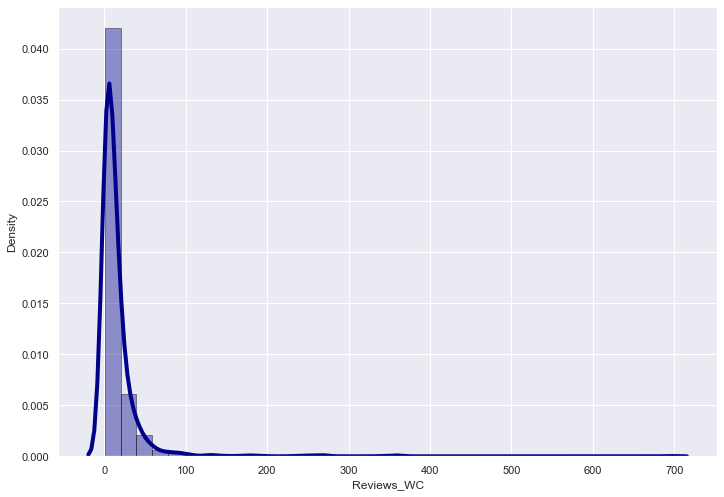

In [52]:
#density plot and histogram of all word count
sns.distplot(df['Reviews_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

Looking at the above histogram we can clearly observe that most of our text is having the number of words in the range of 0 to 100, But some of the reviews are too lengthy which may act like outliers in our data.

Character count

In [53]:
#creating column for character counts in the text
df['Reviews_CC'] = df['Reviews'].str.len()
df[['Reviews_CC','Reviews']].head()

,Reviews_CC,Reviews
0,1078,receive yesterday prompt delivery amazon expe...
1,219,different charger send box amazon ready provid...
2,257,amaze laptop order laptop release date ie th f...
3,1575,soon find gen gen i k get stuck read initial r...
4,178,browser support html video buy lap fool spend ...


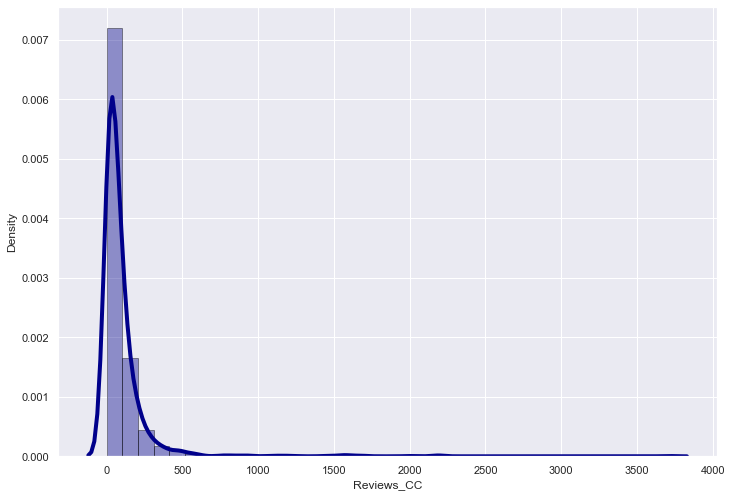

In [54]:
#density plot and histogram of all character count
sns.distplot(df['Reviews_CC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

Above plot represents histogram for character count of review text.

Removing Outliers
As we know that some of the review are too lengthy I am removing those reviews from the dats as outliers using z_score method.

In [55]:
#apply zscore to remove outliers
from scipy import stats
from scipy.stats import zscore
z_score = zscore(df[['Reviews_WC']])
abs_z_score = np.abs(z_score)
filtering_entry = (abs_z_score < 3).all(axis = 1)
df = df[filtering_entry]
df.shape

(2073, 4)

Plotting histograms for word count and character counts again after removing outliers

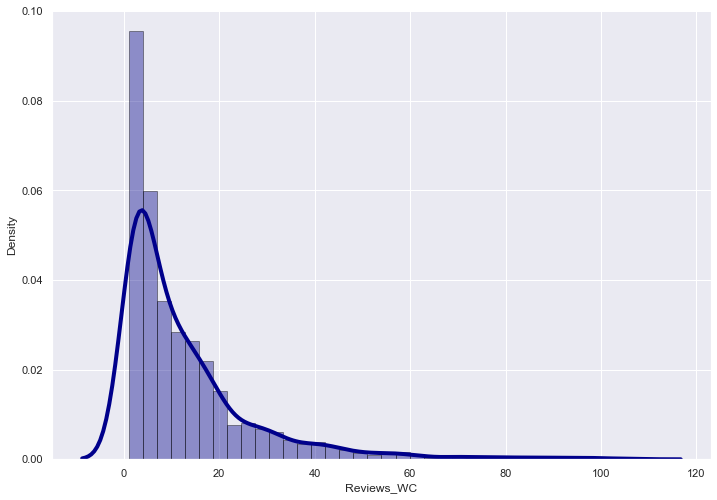

In [56]:
#density plot and histogram of all word count
sns.distplot(df['Reviews_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

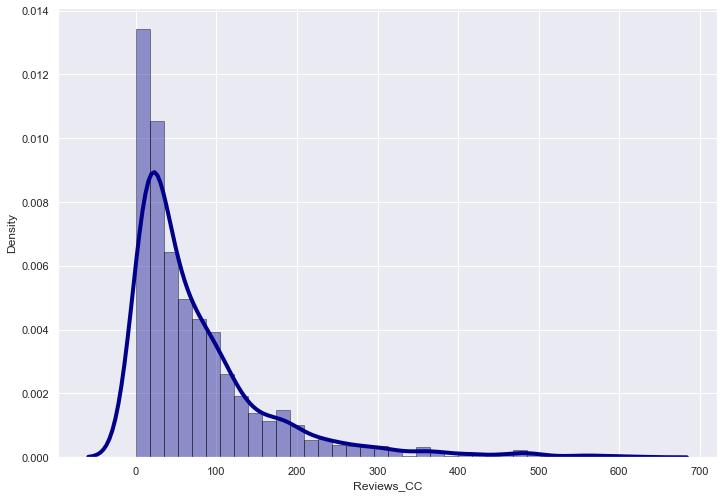

In [57]:
#density plot and histogram of all Character count
sns.distplot(df['Reviews_CC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

After plotting histograms for word counts and character counts after removing outliers we can see now we are with good range of number of words and characters

In [58]:
#lets have a look at our data set
df

,Reviews,Ratings,Reviews_WC,Reviews_CC
1,different charger send box amazon ready provid...,1,32,219
2,amaze laptop order laptop release date ie th f...,5,44,257
4,browser support html video buy lap fool spend ...,1,29,178
5,strange see brand new hp pavilion laptop get h...,1,26,201
7,soon warranty period get laptop get defected c...,1,46,310
...,...,...,...,...
2145,superb get gift brother love much,5,6,33
2146,receive ipad mini appario retailorthought cud ...,4,51,321
2147,poweehouse buy thing game especially free fire...,5,31,192
2148,unbelievable game performance k,5,4,31


5    902
1    557
4    317
3    173
2    124
Name: Ratings, dtype: int64


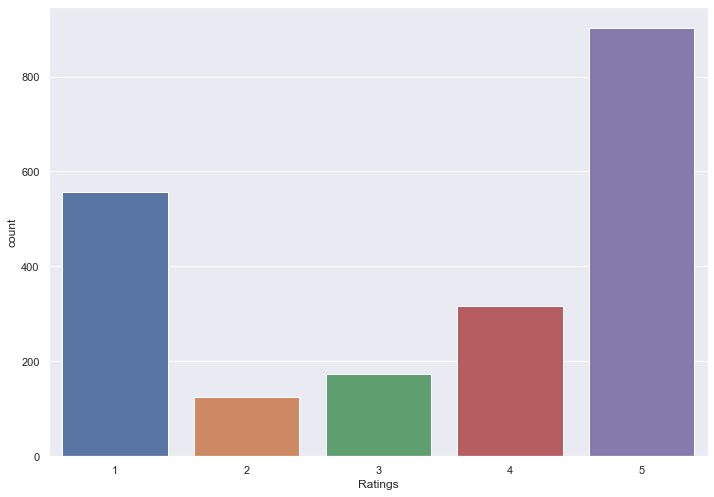

In [59]:
#Check the count of target column
sns.countplot(df['Ratings'])
print(df.Ratings.value_counts())
plt.show()

Looking at the above count plot for our target varible(Ratings) we can say that the data set is having most number of reviews rated as 5 star. and very less number of reviews rated as 2.
Which will cause the Imbalance problem for our model.
So I am selecting equal number of reviews of each rating as a input for our model
For that first I will shuffle the dataset so that we can select data from both web-sites
Then I will select equal number of data of every category

In [60]:
#shuffling the data set
df = df.sample(frac=1).reset_index(drop=True)

In [61]:
df

,Reviews,Ratings,Reviews_WC,Reviews_CC
0,back camera good frot camera worst,3,6,34
1,browser support html video camera quality much...,1,8,51
2,best pubg game battery life good,4,6,32
3,use past month awesome thin light weight anti...,5,23,142
4,best laptop studentsthank appario seller produ...,5,13,89
...,...,...,...,...
2068,company wale beimani kar rahe hai gb expendab...,1,47,207
2069,good phone spend get notes well prime,4,8,38
2070,product ihas deliver get apple pencil st gener...,5,11,74
2071,obviously best tab market,5,4,25


In [62]:
#selct data from every category
df1 = df[df['Ratings']==1][0:500]
df2 = df[df['Ratings']==2][0:500]
df3 = df[df['Ratings']==3][0:500]
df4 = df[df['Ratings']==4][0:500]
df5 = df[df['Ratings']==5][0:500]

In [63]:
#Combining all the dataframes into one and shuffling them 
df = pd.concat([df1,df2,df3,df4,df5],ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df

,Reviews,Ratings,Reviews_WC,Reviews_CC
0,photo clarity upto mark wt expect,1,6,33
1,bed camera quality camera quality satisfactory...,1,34,205
2,overall worth money product look good buying p...,4,26,162
3,camera displayand user interface mean software...,1,19,120
4,need fast charger,5,3,17
...,...,...,...,...
1609,good product price,5,3,18
1610,super performance degree screen movement poss...,4,9,60
1611,camera nice good revolution zoom level excelle...,5,14,89
1612,bad camera photography lover buy thisotherwise...,1,8,55


1    500
5    500
4    317
3    173
2    124
Name: Ratings, dtype: int64


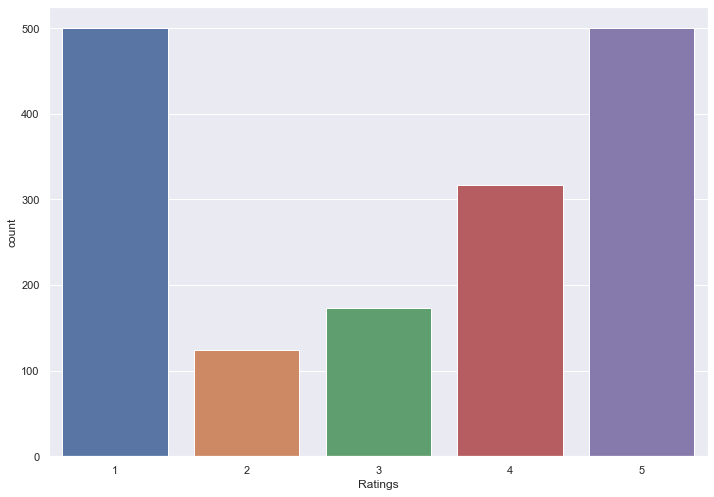

In [64]:
#lets Check the count of target column again
sns.countplot(df['Ratings'])
print(df.Ratings.value_counts())
plt.show()

Top 30 most frequently occuring words

In [65]:
#function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()),
                             'count':list(fdist.values())})
    #selecting top 30 most freq words
    d = words_df.nlargest(columns = 'count', n = terms)
    plt.figure(figsize = (20,10))
    ax = sns.barplot(data = d, x='count', y='word')
    ax.set(ylabel = 'Word')
    plt.show()

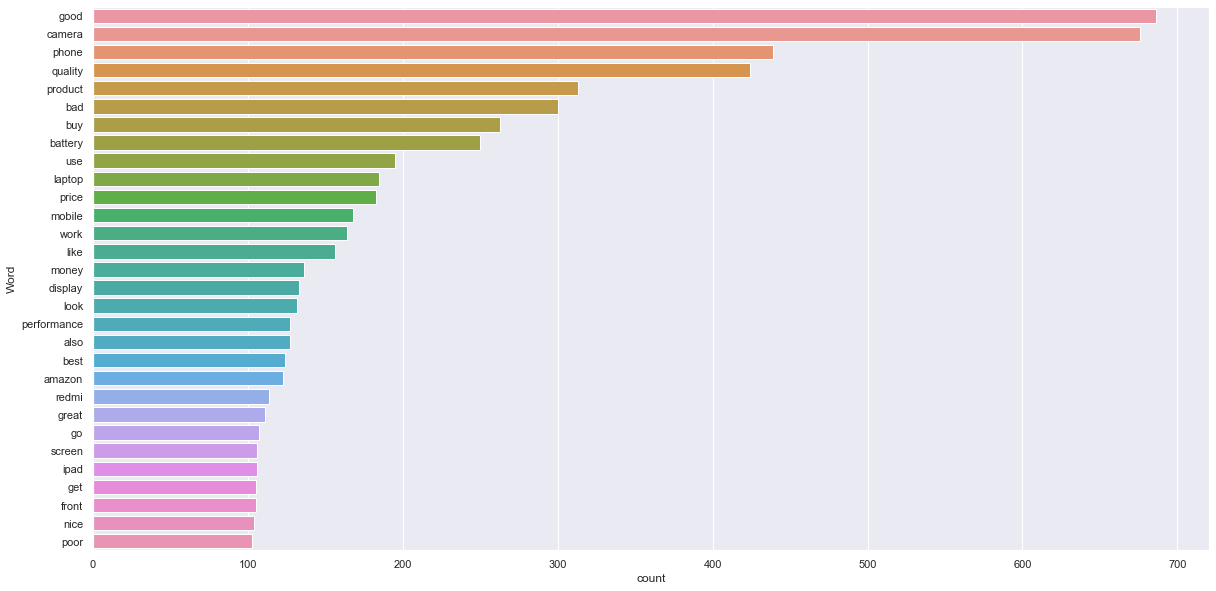

In [66]:
freq_words(df['Reviews'])

Top 30 Rare words

In [67]:
#function to plot least frequent terms
def rare_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()),
                             'count':list(fdist.values())})
    #selecting top 30 most freq words
    d = words_df.nsmallest(columns = 'count', n = terms)
    plt.figure(figsize = (20,10))
    ax = sns.barplot(data = d, x='count', y='word')
    ax.set(ylabel = 'Word')
    plt.show()

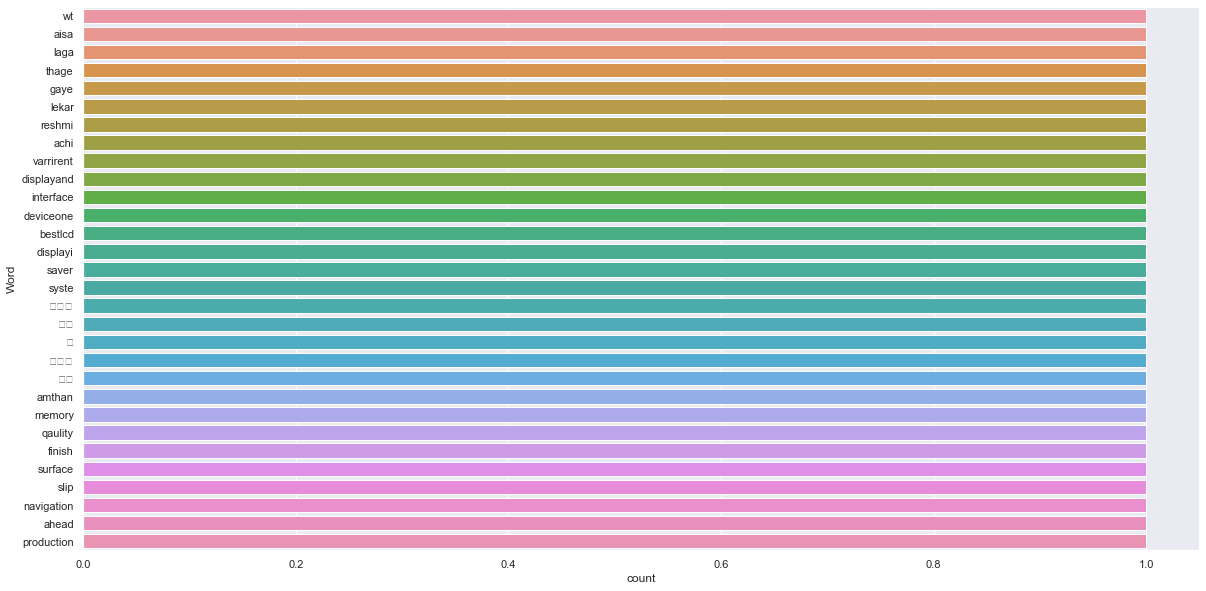

In [68]:
rare_words(df['Reviews'])

In [69]:
!pip install wordcloud

In [70]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
                    background_color='white',
                    stopwords = stopwords,
                    max_words = 500,
                    max_font_size = 40,
                    scale = 3,
                    random_state = 1).generate(str(data))
    fig = plt.figure(1, figsize=(15,15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

Words for rating = 1:

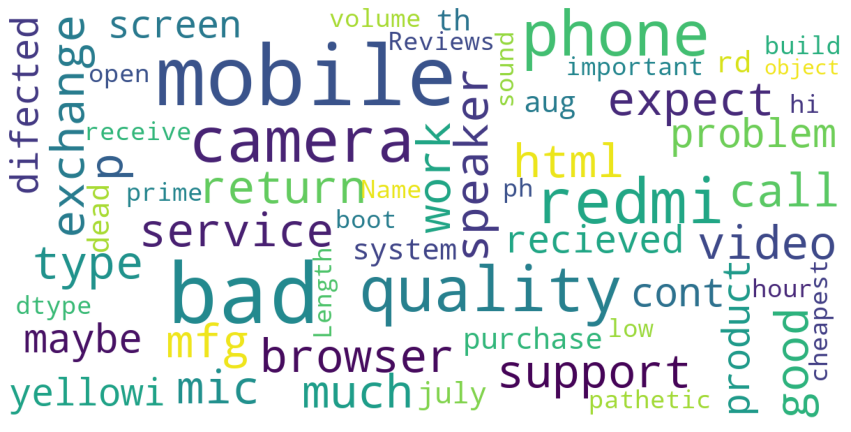

In [71]:
show_wordcloud(df1['Reviews'])

Words for rating = 2:

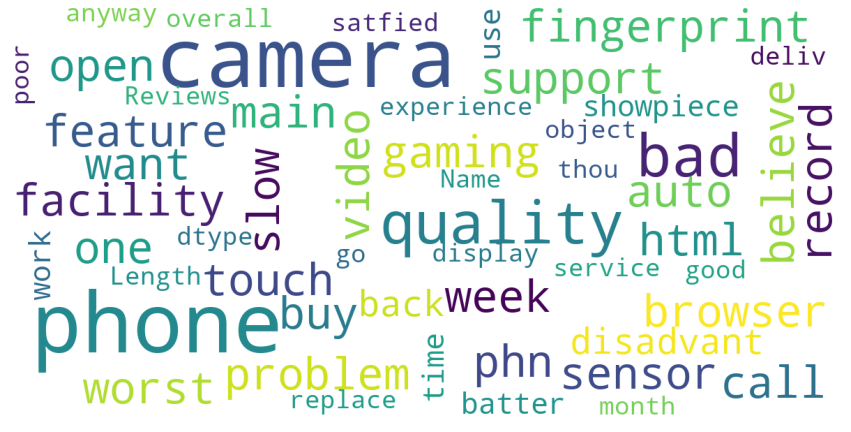

In [72]:
show_wordcloud(df2['Reviews'])

Words for rating = 3:

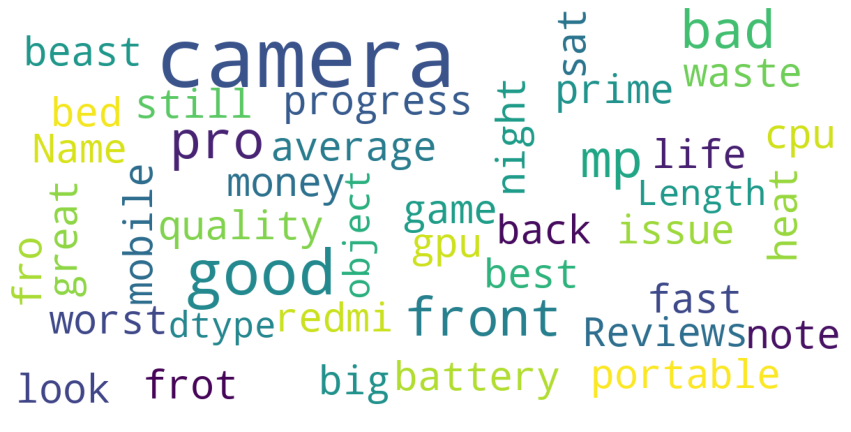

In [73]:
show_wordcloud(df3['Reviews'])

Words for rating = 4:

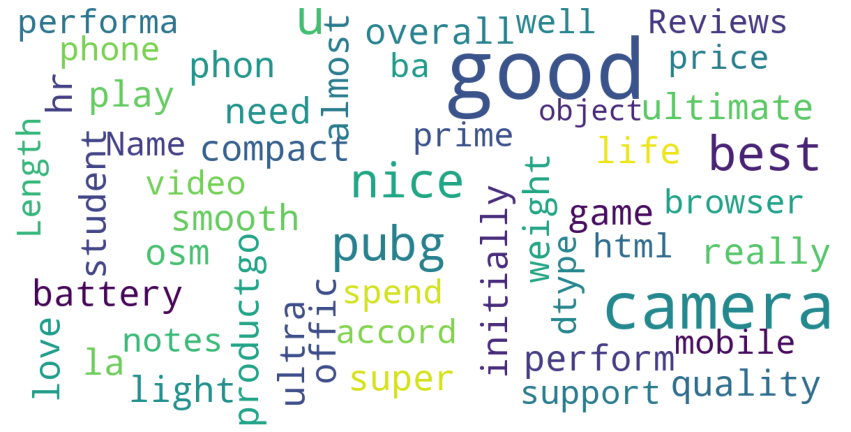

In [74]:
show_wordcloud(df4['Reviews'])

Words for rating = 5:

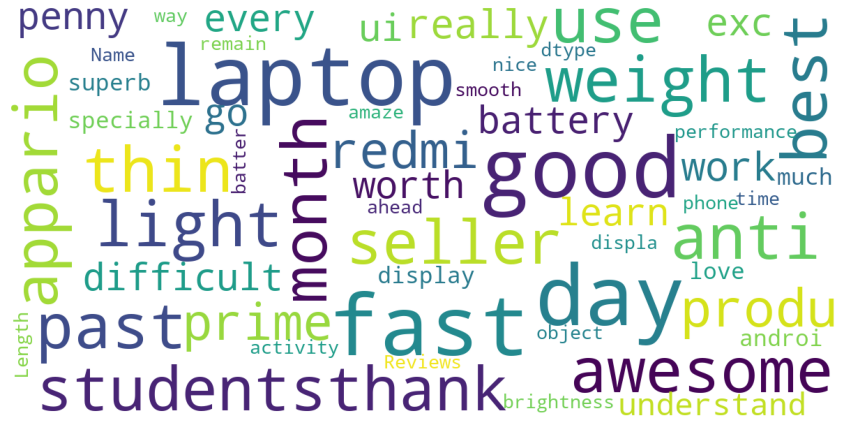

In [75]:
show_wordcloud(df5['Reviews'])

Model Building and Evaluation

In [76]:
#separating features and labels
x = df['Reviews']
y = df['Ratings']

Converting text into vectors using TfidfVectorizer

In [77]:
#using the n_gram tfidf vectorizer(Word vectors)
word_vectorizer = TfidfVectorizer(
                                sublinear_tf = True,
                                strip_accents = 'unicode',
                                analyzer = 'word',
                                token_pattern = r'\w{1,}',
                                stop_words = 'english',
                                ngram_range = (1,3),
                                max_features = 100000)
word_vectorizer.fit(x)
train_word_features = word_vectorizer.transform(x)

In [78]:
#Character vectors
char_vectorizer = TfidfVectorizer(
                                sublinear_tf = True,
                                strip_accents = 'unicode',
                                analyzer = 'char',
                                stop_words = 'english',
                                ngram_range = (2,6),
                                max_features = 50000)
char_vectorizer.fit(x)
train_char_features = char_vectorizer.transform(x)

In [79]:
#I will combine both word vectors and character vectors as input for our model
train_features = hstack([train_char_features,train_word_features])

Splitting the data into train and test

In [80]:
seed = 1
x_train, x_test, y_train, y_test = train_test_split(train_features, y, test_size = 0.25, random_state = seed)

In [81]:
#lets check the shapes of traning and test data
print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

x_train (1210, 75277)
x_test (404, 75277)
y_train (1210,)
y_test (404,)


In [84]:
#defining the algorithms
rf = RandomForestClassifier()
svc = LinearSVC()
lr = LogisticRegression(solver='lbfgs')
mnb = MultinomialNB()
bnb = BernoulliNB()
sgd = SGDClassifier()

In [85]:
#creating a function to train and test the model with evaluation
def BuiltModel(model):
    print('*'*30+model.__class__.__name__+'*'*30)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_train)
    pred = model.predict(x_test)

    accuracy = accuracy_score(y_test,pred)*100

    print(f"Accuracy Score:", accuracy)
    print("---------------------------------------------------")

    #confusion matrix & classification report
    
    print(f"CLASSIFICATION REPORT : \n {classification_report(y_test,pred)}")
    print(f"Confusion Matrix : \n {confusion_matrix(y_test,pred)}\n")

In [87]:
for model in [lr,svc,bnb,mnb,sgd,rf]:
    BuiltModel(model)

******************************LogisticRegression******************************
Accuracy Score: 63.613861386138616
---------------------------------------------------
CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.66      0.87      0.75       131
           2       0.60      0.09      0.15        34
           3       0.50      0.19      0.28        36
           4       0.51      0.30      0.38        74
           5       0.66      0.86      0.74       129

    accuracy                           0.64       404
   macro avg       0.59      0.46      0.46       404
weighted avg       0.61      0.64      0.59       404

Confusion Matrix : 
 [[114   1   3   5   8]
 [ 22   3   2   3   4]
 [ 14   0   7   8   7]
 [ 12   1   0  22  39]
 [ 11   0   2   5 111]]

******************************LinearSVC******************************
Accuracy Score: 61.88118811881188
---------------------------------------------------
CLASSIFICATION REPORT : 


Cross validation

In [88]:
def cross_val(model):
    print('*'*30+model.__class__.__name__+'*'*30)
    scores = cross_val_score(model,train_features,y, cv = 3).mean()*100
    print("Cross validation score :", scores)

In [89]:
for model in [lr,svc,sgd,rf]:
    cross_val(model)

******************************LogisticRegression******************************
Cross validation score : 61.77199504337051
******************************LinearSVC******************************
Cross validation score : 61.4622057001239
******************************SGDClassifier******************************
Cross validation score : 60.842627013630725
******************************RandomForestClassifier******************************
Cross validation score : 58.42627013630731


algorithms are giving good cv scores with very less difference in accuracy and cv-scores. Among these algorithms I am selecting LinearSVC as best suitable algorithm for our final model as it is giving least difference in accuracy and cv score with higher accuracy.

HyperParameter Tuning

In [90]:
#lets selects different parameters for tuning
grid_params = {
                'penalty':['l2'],
                'loss':['hinge','squared_hinge'],
                'multi_class': ['ovr'],
                'intercept_scaling':[2,3],
                'dual':[True,False],
                }

In [91]:
#train the model with given parameters using GridSearchCV
GCV =  GridSearchCV(svc, grid_params, cv = 3, verbose=10)
GCV.fit(x_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 1/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2; total time=   1.3s
[CV 2/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 2/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2; total time=   0.4s
[CV 3/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 3/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2; total time=   0.3s
[CV 1/3; 2/8] START dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2
[CV 1/3; 2/8] END dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2; total time=   0.4s
[CV 2/3; 2/8] START dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2
[CV 2/3; 2/8] EN

GridSearchCV(cv=3, estimator=LinearSVC(),
             param_grid={'dual': [True, False], 'intercept_scaling': [2, 3],
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr'], 'penalty': ['l2']},
             verbose=10)

In [92]:
GCV.best_params_       #printing the best parameters found by GridSearchCV

{'dual': True,
 'intercept_scaling': 2,
 'loss': 'hinge',
 'multi_class': 'ovr',
 'penalty': 'l2'}

In [93]:
#training and testing our final model with above parameters
model = LinearSVC(dual = True, intercept_scaling = 2, loss = 'hinge', multi_class = 'ovr', penalty = 'l2')
model.fit(x_train,y_train) #fitting data to model
pred = model.predict(x_test)
accuracy = accuracy_score(y_test,pred)*100

#printing accuracy score
print("Accuracy Score :", accuracy)

#printing Confusion matrix
print(f"\nConfusion Matrix : \n {confusion_matrix(y_test,pred)}\n")

#printing Classification report
print(f"\nCLASSIFICATION REPORT : \n {classification_report(y_test,pred)}")

Accuracy Score : 62.62376237623762

Confusion Matrix : 
 [[102   7  10   6   6]
 [ 16   6   3   5   4]
 [ 13   1   9   7   6]
 [  8   4   2  26  34]
 [ 11   0   2   6 110]]


CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.68      0.78      0.73       131
           2       0.33      0.18      0.23        34
           3       0.35      0.25      0.29        36
           4       0.52      0.35      0.42        74
           5       0.69      0.85      0.76       129

    accuracy                           0.63       404
   macro avg       0.51      0.48      0.49       404
weighted avg       0.59      0.63      0.60       404



# Model Saving

In [94]:
import joblib
joblib.dump(model,"Rating_Prediction.pkl")

['Rating_Prediction.pkl']

Finally I am saving this model into a .pkl file

Conclusion:
Key findings of the study :

In this project I have collected data of reviews and ratings for different products from amazon.in and flipkart.com. Then I have done different text processing for reviews column and chose equal number of text from each rating class to eliminate problem of imbalance. By doing different EDA steps I have analyzed the text. We have checked frequently occurring words in our data as well as rarely occurring words. After all these steps I have built function to train and test different algorithms and using various evaluation metrics I have selected LinearSVC for our final model. Finally by doing hyperparameter tuning we got optimum parameters for our final model. And finally we got improved accuracy score for our final model.